# Viseklasna klasifikacija bez prethodne vece izmene podataka

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import losses, optimizers

from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn import datasets
from sklearn import model_selection

from sklearn.decomposition import PCA

np.random.seed(10)

import category_encoders as ce

from keras.callbacks import TensorBoard

from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
# Ucitavanje podataka iz skupa sa imenima klasa
data = pd.read_csv('kddcup.csv.data_10_percent_corrected')

In [3]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


U svesci Provera reprezentativnosti uzorka + informacije o podacima, saznali smo da atributi 'num_outbound_cmds' i 'is_host_login' imaju sve 0, samim tim, nisu od znacaja za ucenje naseg modela pa se izbacuju.

In [6]:
data.drop(columns = ['num_outbound_cmds', 'is_host_login'], axis = 1, inplace = True)

In [7]:
y = data['class']

In [8]:
y.head()

0    normal.
1    normal.
2    normal.
3    normal.
4    normal.
Name: class, dtype: object

In [9]:
y = y.astype('category')

In [10]:
y = y.cat.codes

In [11]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22], dtype=int8)

In [12]:
# Binarno kodiranje kategorickih kolona
encoder = ce.BinaryEncoder(data, cols = ['protocol_type', 'service', 'flag'])
X = encoder.fit_transform(data)

In [13]:
X.head()

,duration,protocol_type_0,protocol_type_1,protocol_type_2,service_0,service_1,service_2,service_3,service_4,service_5,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,0,0,1,0,0,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,0,0,1,0,0,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,0,0,1,0,0,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,0,0,1,0,0,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,0,0,1,0,0,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [14]:
X.shape

(494021, 53)

In [15]:
# Iz podataka izbacujemo kolonu sa klasom
X = X.drop(columns = ['class'])

In [16]:
X.head()

,duration,protocol_type_0,protocol_type_1,protocol_type_2,service_0,service_1,service_2,service_3,service_4,service_5,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,0,1,0,0,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1,0,0,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,0,0,1,0,0,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,0,0,1,0,0,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,0,0,1,0,0,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [17]:
# Podatke delimo na trening i test skup u odnosu 2:1
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [18]:
X_train.shape

(330994, 52)

In [19]:
X_test.shape

(163027, 52)

In [20]:
y_train.shape

(330994, 23)

In [21]:
y_test.shape

(163027, 23)

In [22]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0.], dtype=float32)

In [23]:
# Skaliranje podataka

scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
model = Sequential()
model.add(Dense(units=150, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=23, activation='softmax'))

In [25]:
model.compile(optimizers.Adam(learning_rate = 0.0001), loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [26]:
batch_size = 128
epochs = 30

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/30
330994/330994 [==============================] - 42s 127us/step - loss: 0.2151 - accuracy: 0.9762
Epoch 2/30
330994/330994 [==============================] - 24s 74us/step - loss: 0.0115 - accuracy: 0.9976
Epoch 3/30
330994/330994 [==============================] - 25s 76us/step - loss: 0.0071 - accuracy: 0.9986
Epoch 4/30
330994/330994 [==============================] - 24s 73us/step - loss: 0.0054 - accuracy: 0.9990
Epoch 5/30
330994/330994 [==============================] - 24s 74us/step - loss: 0.0045 - accuracy: 0.9991
Epoch 6/30
330994/330994 [==============================] - 24s 74us/step - loss: 0.0038 - accuracy: 0.9992
Epoch 7/30
330994/330994 [==============================] - 26s 79us/step - loss: 0.0035 - accuracy: 0.9993
Epoch 8/30
330994/330994 [==============================] - 25s 77us/step - loss: 0.0033 - accuracy: 0.9993
Epoch 9/30
330994/330994 [==============================] - 24s 72us/step - loss: 0.0031 - accuracy: 0.9994
Epoch 10/30
330994/330994 [

In [27]:
score = model.evaluate(X_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

163027/163027 [==============================] - 33s 203us/step
Test loss: 0.08620104532812546
Test accuracy: 0.9994786381721497


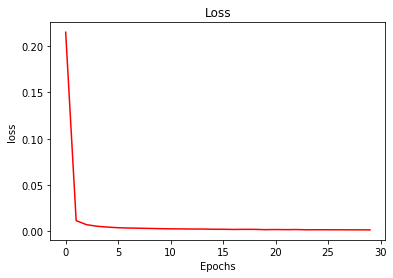

In [28]:
epochs = history.epoch

loss = history.history['loss']

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(epochs, loss, c='red')
plt.show()

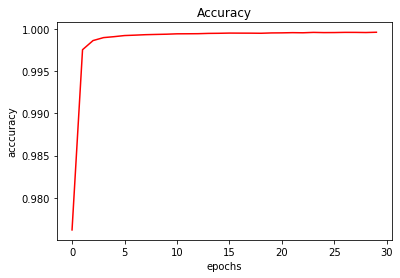

In [29]:
acc = history.history['accuracy']

plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('acccuracy')
plt.plot(epochs, acc, c='red')
plt.show()

In [30]:
y_predicted = model.predict(X_test)
y_predicted_classes = np.argmax(y_predicted, axis = 1)

In [31]:
y_test_classes = np.argmax(y_test, axis = 1)

In [32]:
print(confusion_matrix(y_test_classes, y_predicted_classes))

[[  727     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     7     0     0     0     0     0     0     0     0     0     2
      0     0     0     0     0     0     0     0     0     1     0]
 [    0     0     1     0     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     1     0]
 [    0     0     0    16     0     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     3     0     0     0     0     0     0     1
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0   408     0     0     0     0     1     3
      0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     7     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0]

In [33]:
print(classification_report(y_test_classes, y_predicted_classes))

/home/vladana/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       0.88      0.70      0.78        10
           2       1.00      0.33      0.50         3
           3       1.00      0.94      0.97        17
           4       1.00      0.75      0.86         4
           5       0.99      0.99      0.99       412
           6       1.00      1.00      1.00         7
           7       1.00      0.33      0.50         3
           8       0.50      0.50      0.50         2
           9       1.00      1.00      1.00     35376
          10       0.96      1.00      0.98        76
          11       1.00      1.00      1.00     32102
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00        87
          15       1.00      0.99      0.99       343
          16       0.00      0.00      0.00         3
          17       0.99    